<a href="https://colab.research.google.com/github/genji970/3d-ai-computervision-reconstruction/blob/main/covid_detection_by_reconstructing_2d_to_3d_image_using_depth_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision diffusers transformers accelerate pycocotools open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torchvision.utils import save_image
from diffusers import UNet2DModel
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
from PIL import Image
import open3d as o3d

#깊이 추정 패키지
import cv2
from transformers import DPTForDepthEstimation, DPTFeatureExtractor

from transformers import AutoFeatureExtractor

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
from google.colab.patches import cv2_imshow

데이터 다운

In [ ]:
# Kaggle API 설치
!pip install kaggle

# kaggle.json 파일 업로드
from google.colab import files
files.upload()  # 'kaggle.json' 파일을 업로드합니다.

# Kaggle 폴더 생성 및 권한 설정
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# 데이터셋 다운로드
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

# 압축 해제
!unzip covid19-radiography-database.zip -d covid19_xray

In [ ]:
# 데이터 경로 설정
data_dir = '/content/covid19_xray/COVID-19_Radiography_Dataset'

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 데이터셋 로드
dataset = datasets.ImageFolder(os.path.join(data_dir, 'COVID'), transform=transform)
# DataLoader 설정
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 데이터셋 크기 확인
print(f'총 이미지 수: {len(dataset)}')

총 이미지 수: 7232


시각화

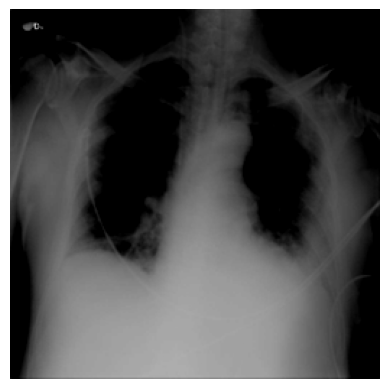

Label: images


In [ ]:
# 한 장의 이미지 가져오기
image, label = dataset[0]

# 텐서를 numpy 배열로 변환 후 시각화
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # (C, H, W) → (H, W, C)
    img = np.clip(img, 0, 1)  # 정규화된 값 클리핑
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# 첫 번째 이미지 시각화
imshow(image)
print(f'Label: {dataset.classes[label]}')  # 클래스명 출력

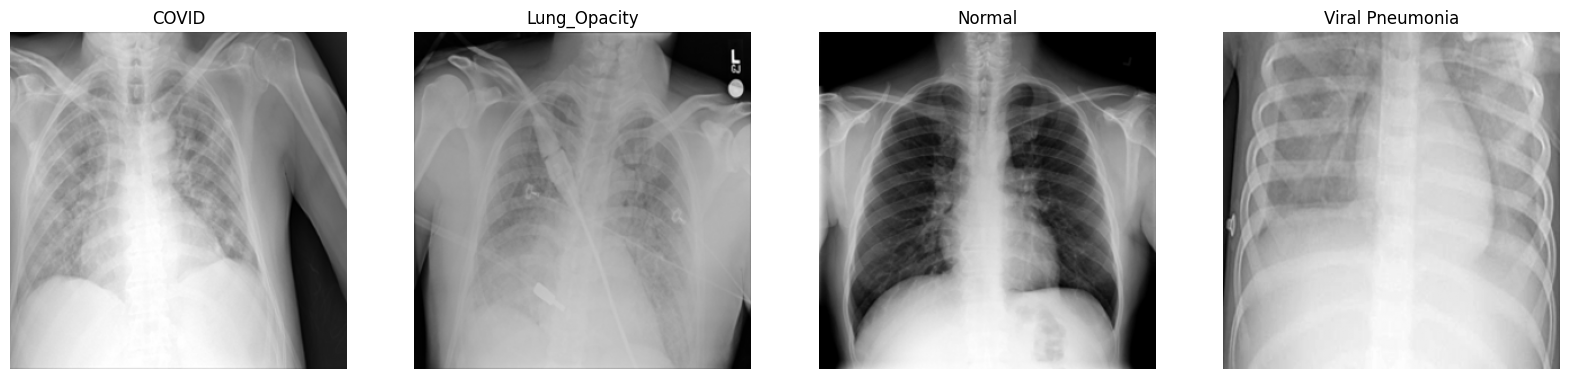

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

# 데이터셋 경로
categories = ['COVID','Lung_Opacity','Normal','Viral Pneumonia']

# 4개 카테고리에서 랜덤 이미지 선택 및 시각화
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, category in enumerate(categories):
    path = os.path.join(data_dir, category)
    image_path=os.path.join(path,'images')
    mask_path=os.path.join(path,'masks')
    file = random.choice(os.listdir(image_path))
    img = Image.open(os.path.join(image_path, file)).convert("L")  # 흑백 변환
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(category)
    axes[i].axis("off")

plt.show()

# **깊이 추정**

In [ ]:
# 모델 로드
model_name = "Intel/dpt-large"
model = DPTForDepthEstimation.from_pretrained(model_name)
feature_extractor = DPTFeatureExtractor.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


In [ ]:
# 데이터셋 경로
categories = ['COVID','Lung_Opacity','Normal','Viral Pneumonia']

for i, category in enumerate(categories):
    path = os.path.join(data_dir, category)
    image_path=os.path.join(path,'images')
    mask_path=os.path.join(path,'masks')
    files = sorted(os.listdir(image_path))
    for file in files:
      file_path = os.path.join(image_path , file)
      img = cv2.imread(file_path)

      if img is None:
        print(f"파일 {file_path}을 불러올 수 없습니다.")
        continue

      img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      img = img.convert("L")

      img = cv2.cvtColor(np.array(img), cv2.COLOR_GRAY2RGB)

      image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      inputs = feature_extractor(images=image, return_tensors="pt")

      # 깊이 추정
      with torch.no_grad():
        outputs = model(**inputs)

        if not hasattr(outputs, "predicted_depth"):
          print("오류: 모델 출력에 'predicted_depth'가 없음.")
          continue

        depth = outputs.predicted_depth.squeeze().numpy()

      # 깊이 맵 정규화 및 시각화
      depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255
      depth = depth.astype(np.uint8)

      # 2d 이미지 , 깊이 맵

      if image is None or depth is None:
        raise FileNotFoundError("이미지 또는 깊이맵을 불러올 수 없습니다.")


      # ✅ 3. 카메라 내부 파라미터 설정 (가상의 값, 실제 데이터에 맞춰 수정 필요)
      focal_length = 500  # 초점 거리
      cx, cy = image.shape[1] // 2, image.shape[0] // 2  # 이미지 중심점
      intrinsics = np.array([[focal_length, 0, cx],
                       [0, focal_length, cy],
                       [0, 0, 1]])

      # ✅ 4. 3D 포인트 클라우드 생성
      h, w = depth.shape
      x, y = np.meshgrid(np.arange(w), np.arange(h))
      z = depth  # 깊이 값 그대로 사용
      x = (x - cx) * z / focal_length
      y = (y - cy) * z / focal_length

      # ✅ 5. 포인트 클라우드 배열 생성 (X, Y, Z 좌표)
      points_3d = np.stack((x, y, z), axis=-1).reshape(-1, 3)

      # ✅ 6. 색상 정보 추가
      colors = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).reshape(-1, 3) / 255.0  # 0~1로 변환

      # ✅ 7. Open3D를 사용하여 시각화
      #pcd = o3d.geometry.PointCloud()
      #pcd.points = o3d.utility.Vector3dVector(points_3d)
      #pcd.colors = o3d.utility.Vector3dVector(colors)



      # ✅ 13. Colab 및 GUI 없는 환경에서 시각화 방법 선택
      #try:
      #  o3d.visualization.draw_geometries_with_matplotlib([pcd])  # GUI 환경 (로컬)에서 실행 가능
      #except:
      #  print("[⚠️ Warning] OpenGL 기반 시각화 불가! Colab에서 Matplotlib을 사용합니다.")
      #  o3d.visualization.draw_geometries_with_matplotlib([pcd])

      # ✅ WebRTC 기반 렌더링 활성화
      o3d.visualization.webrtc_server.enable_webrtc()

      # ✅ 샘플 포인트 클라우드 생성
      pcd = o3d.geometry.PointCloud()
      pcd.points = o3d.utility.Vector3dVector(np.random.rand(1000, 3))  # 랜덤 3D 좌표

      # ✅ WebRTC 기반 시각화 (Colab에서도 가능)
      o3d.visualization.draw(pcd)

# **main**

In [ ]:
# 하이퍼파라미터 설정
image_size = 32
timesteps = 1000
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# 노이즈 일정표 (Beta Schedule) 설정
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

In [ ]:
betas = linear_beta_schedule(timesteps)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)  # \bar{\alpha}_t

In [ ]:
# 노이즈 추가 (Forward Diffusion)
def add_noise(image, t, noise=None):
    if noise is None:
        noise = torch.randn_like(image)
    alpha_t = alphas_cumprod[t].view(-1, 1, 1, 1).to(device)
    return torch.sqrt(alpha_t) * image + torch.sqrt(1 - alpha_t)

In [ ]:
# U-Net 모델 정의 (Diffusers 라이브러리 활용)
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.unet = UNet2DModel(
            sample_size=image_size,
            in_channels=3,
            out_channels=3,
            layers_per_block=2,
            block_out_channels=(64, 128, 256, 512),
            down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D"),
            up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D")
        )

    def forward(self, x, t):
        return self.unet(x, t).sample  # 노이즈 예측 결과 반환

In [ ]:
# 모델 초기화
model = SimpleUNet().to(device)

In [ ]:
# 역방향 확산 과정 (Reverse Diffusion)
@torch.no_grad()
def sample_images(model, num_images=4):
    images = torch.randn((num_images, 3, image_size, image_size)).to(device)  # 무작위 노이즈 초기화
    for t in reversed(range(1, timesteps)):
        t_tensor = torch.tensor([t], dtype=torch.long).to(device)
        predicted_noise = model(images, t_tensor)
        alpha_t = alphas_cumprod[t].view(-1, 1, 1, 1).to(device)
        beta_t = betas[t].view(-1, 1, 1, 1).to(device)
        noise = torch.randn_like(images) if t > 1 else torch.zeros_like(images)
        images = (1 / torch.sqrt(alpha_t)) * (images - beta_t / torch.sqrt(1 - alpha_t) * predicted_noise) + torch.sqrt(beta_t) * noise
    return images

In [ ]:
# 샘플 이미지 생성 및 저장
def generate_images():
    model.eval()
    images = sample_images(model, num_images=4)
    save_image(images, "generated_images.png", nrow=2)
    plt.imshow(np.transpose(images.cpu().numpy()[0], (1, 2, 0)))
    plt.show()

In [ ]:
generate_images()